# Image classification using the Emnist digits dataset

## imports

In [1]:
import sys
import os
import sklearn
import time
import joblib
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Callback setup

In [2]:
# Define the root log directory.
root_logdir = os.path.join(os.curdir, "my_logs")

In [3]:
# Create a function which will generate a subdirectory path based on current date and time.
# This is needed for TensorBoard.
def get_run_logdir():
    run_id =time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2022_03_24-19_11_42'

In [4]:
#Define callbacks.

# ModelCheckpoint.
# Saves checkpoints of the model at regular intervals.
checkpoint_cb = keras.callbacks.ModelCheckpoint("emnist_digits.h5", save_best_only=True)

# EarlyStopping (with rollback to the best model).
# Interrupts training when it measures no progress on the validation set for 10 epochs.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# TensorBoard.
# Saves data in log files at regular intervals to later display this data in TensorBoard.
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Performance Scheduling.
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

## Load the data

In [5]:
# I decided to install emnist by using:
# python3 –m pip install emnist
# This is to download and load the dataset.
from emnist import extract_training_samples, extract_test_samples
emnist_digits = extract_training_samples, extract_test_samples
x_train_full, y_train_full = extract_training_samples('digits')
x_test, y_test = extract_test_samples('digits')

In [6]:
# Show the size and dimension of the data.
# Each pixel intesity is represented as a byte (0 to 255).
x_train_full.shape, x_train_full.dtype, y_train_full.shape, y_train_full.dtype

((240000, 28, 28), dtype('uint8'), (240000,), dtype('uint8'))

In [7]:
# The full data is split into a validation and a smaller training set.
# The pixel intensities are scaled down to a 0-1 range and converted to a float.
x_valid, x_train = x_train_full[:5000] / 255., x_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255.

### Visualize the data

In [8]:
# Show the size and dimension of the splitted data.
x_train.shape, x_valid.shape, x_test.shape

((235000, 28, 28), (5000, 28, 28), (40000, 28, 28))

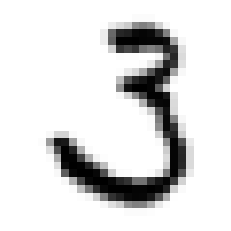

In [9]:
# Plot one image of each using Matplotlib's imshow() function, which a binary color map:
plt.imshow(x_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [10]:
# The labels are the class IDs from 0 to 9.
y_train

array([3, 6, 0, ..., 1, 1, 0], dtype=uint8)

In [11]:
# Defining the class names.
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [12]:
# Show the class name of the first iamgine in the training set.
class_names[y_train[0]]

'3'

## Standardize the data

In [13]:
# Compute the mean for each pixel.
pixel_means = x_train.mean(axis=0)
pixel_means.shape

(28, 28)

In [ ]:
# Compute the standard deviation for each pixel.
pixel_stds = (x_train.std(axis=0)+0.000001)
pixel_stds.shape

In [ ]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
x_train_standardized = (x_train - pixel_means) / pixel_stds

x_valid_standardized = (x_valid - x_valid.mean(axis=0)) / (x_valid.std(axis=0)+0.000001)
x_test_standardized = (x_test - x_test.mean(axis=0)) / (x_test.std(axis=0)+0.000001)

In [ ]:
# Validate that the mean is close to 0 for each pixel.
x_train_standardized.mean(axis=0)

In [ ]:
# Validate that the standard deviation is close to 1 for each pixel.
x_train_standardized.std(axis=0)

## Create a model

### Sequential
Skip this is if you wish to run the model with hyperparameter tuning.

In [ ]:
# The input layer is made by flatten to convert each input image into a 1-dimensional array.
# Two hidden layers is made by dense to make them fully connected (300 neurons and relu).
# Alpha dropout regularization is used in the last hidden layer.
# The output layer contains one neuron per class. Softmax because multiclass classifier.

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(7):
    model.add(keras.layers.Dense(400, activation="selu", kernel_initializer="lecun_normal"))
    #model.add(keras.layers.Dense(400, activation="relu"))
model.add(keras.layers.AlphaDropout(rate=0.2))
#model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(10, activation="softmax"))

#### Show information about the sequential model

In [ ]:
model.summary

In [ ]:
hidden1 = model.layers[1]
hidden1.name

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights, weights.shape

In [ ]:
biases, biases.shape

#### Compile the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(momentum=0.9),
             metrics=["accuracy"])

## Train the model
(If you wish to load an already compiled and trained model scroll to the end of the notebook.)

In [ ]:
# Keras will measure the loss and the extra metrics on the validation set at the end of each epoch.
# The number of epochs is here set to 30.
# We use the default batch-size.
history = model.fit(x_train_standardized, y_train, epochs=30,
                    validation_data=(x_valid_standardized, y_valid),
                    callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

In [ ]:
# Show the learning curves.
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show

## Evaluate the model

In [ ]:
# Evaluate the model on the test set.
model.evaluate(x_test_standardized, y_test)

##### Observations:
Using 400 neurons and 7 hidden layers, selu, lecun, all callbacks and alpha dropout:<br> [0.05326846241950989, 0.9910749793052673]

Using 300 neurons and 2 hidden layers, selu, lecun, all callbacks and alpha dropout:<br> [0.08781340718269348, 0.9824000000953674]

Using 300 neurons and 2 hidden layers, relu, all callbacks and alpha dropout: <br> [0.04303058236837387, 0.9913750290870667]

Using 300 neurons and 2 hidden layers, relu, all callbacks and dropout: <br> [0.030846111476421356, 0.9906749725341797]

In [ ]:
# Make predictions with probabilities for the first three instances in the training set.
x_new = x_test_standardized[:3]
y_proba = model.predict(x_new)
y_proba.round(2)

In [ ]:
# Make predictions without probabilities.
y_pred = np.argmax(model.predict(x_new), axis=-1)
y_pred

In [ ]:
# Check if the predictions were correct.
y_new = y_test[:3]
y_new

In [ ]:
# Show the names of the predicted.
np.array(class_names)[y_pred]

### Hyperparameter tuning with RandomizedSearchCV
(If you wish to load an already compiled and trained model scroll to the end of the notebook.)

In [ ]:
# Create a function that will build and compile a Keras model.
def build_model(n_hidden=1, n_neurons=100, learning_rate=3e-3, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        #model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.AlphaDropout(rate=0.2))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(momentum=0.9)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [ ]:
# Wrap the Keras model in a Scikit-Learn KerasClassifier.
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter set and ranges to explore.
param_distribs = {
    "n_hidden": [1, 2, 3, 7, 10],
    "n_neurons": [100, 200, 300, 400, 600]
}

# Create an instances of RandomizedSearchCV
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=25, cv=3, n_jobs=-1, verbose=2)

# Search
rnd_search_cv.fit(x_train_standardized, y_train, epochs=60,
                 validation_data=(x_valid_standardized, y_valid),
                 callbacks=[lr_scheduler, checkpoint_cb, tensorboard_cb, early_stopping_cb])

In [ ]:
# Display the parameters and score of the best model.
rnd_search_cv.best_params_, rnd_search_cv.best_score_

##### Observations:
Using relu the best params and score was: {'n_neurons': 300, 'n_hidden': 2}, 0.9896297852198283 <br>
Using selu and lecun the best params and score was:({'n_neurons': 400, 'n_hidden': 7}, 0.9887957572937012)

In [ ]:
# Get the model for the best estimator and evaluate it on the test set.
rnd_search_model = rnd_search_cv.best_estimator_.model
rnd_search_model.evaluate(x_test_standardized, y_test)

##### Observations:
Using relu the best accuracy was: [0.04202648624777794, 0.9904999732971191] <br>
Using selu and lecun the best accuracy was: [0.05357888340950012, 0.9907749891281128]

### Display learning curves in TensorBoard

In [ ]:
%load_ext tensorboard

%tensorboard --logdir=./my_logs --port=6006

### Save and load a model

#### Keras object:

In [ ]:
model.save("emnist_digits.h5")

In [ ]:
model = keras.models.load_model("emnist_digits.h5")

#### RandomizedSearchCV object:

In [ ]:
# Save rnd_search_cv model
joblib.dump(rnd_search_cv, 'rnd_search_cv-selu.pkl')

In [ ]:
# Restore rnd_search_cv model for further usage
joblib.load("rnd_search_cv.pkl")